## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Терёхина Ирина Юрьевна

In [107]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import train_utils
from IPython.display import clear_output
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

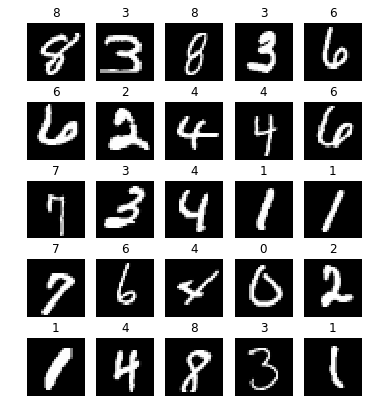

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [61]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [62]:
def new_linear_layer(input_size, output_size, mean, std):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, mean, std)
    return layer

In [102]:
mean = 0
std = 0.1

for act_fn in [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.ELU()]:
    layers = []
    print(act_fn)
    layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(std)))
    layers.append(act_fn)
    for i in range(10):
        layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(std)))
        layers.append(act_fn)
    layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(std)))
    layers.append(nn.LogSoftmax(dim=1))
    network = nn.Sequential(*layers)

    #пример:
    n_objects = 100
    X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
    y = Variable(labels_train[:n_objects], requires_grad=False)
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()
    print()

ReLU()
forward tensor(0.9977)
forward tensor(5.2969, grad_fn=<StdBackward0>)
forward tensor(26.4993, grad_fn=<StdBackward0>)
forward tensor(131.9148, grad_fn=<StdBackward0>)
forward tensor(651.1633, grad_fn=<StdBackward0>)
forward tensor(3275.1787, grad_fn=<StdBackward0>)
forward tensor(16415.0039, grad_fn=<StdBackward0>)
forward tensor(83654.5078, grad_fn=<StdBackward0>)
forward tensor(386476.4375, grad_fn=<StdBackward0>)
forward tensor(1910077., grad_fn=<StdBackward0>)
forward tensor(9761335., grad_fn=<StdBackward0>)
forward tensor(45900476., grad_fn=<StdBackward0>)
backward tensor(0.1566)
backward tensor(0.0973)
backward tensor(0.4762)
backward tensor(2.2240)
backward tensor(10.3932)
backward tensor(51.8192)
backward tensor(246.2772)
backward tensor(1125.6047)
backward tensor(4806.5732)
backward tensor(22734.0293)
backward tensor(107264.9766)
backward tensor(490513.3125)

Sigmoid()
forward tensor(0.9977)
forward tensor(0.4522, grad_fn=<StdBackward0>)
forward tensor(0.4162, grad_fn=<

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [101]:
mean = 0
std = 0.1
print('He initialization')
print()
for act_fn in [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.ELU()]:
    layers = []
    print(act_fn)
    layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500)))
    layers.append(act_fn)
    for i in range(10):
        layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500)))
        layers.append(act_fn)
    layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10)))
    layers.append(nn.LogSoftmax(dim=1))
    network = nn.Sequential(*layers)

    #пример:
    n_objects = 100
    X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
    y = Variable(labels_train[:n_objects], requires_grad=False)
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()
    print()

He initialization

ReLU()
forward tensor(0.9977)
forward tensor(1.0693, grad_fn=<StdBackward0>)
forward tensor(1.0772, grad_fn=<StdBackward0>)
forward tensor(1.1676, grad_fn=<StdBackward0>)
forward tensor(1.1696, grad_fn=<StdBackward0>)
forward tensor(1.2641, grad_fn=<StdBackward0>)
forward tensor(1.2811, grad_fn=<StdBackward0>)
forward tensor(1.2449, grad_fn=<StdBackward0>)
forward tensor(1.2885, grad_fn=<StdBackward0>)
forward tensor(1.2979, grad_fn=<StdBackward0>)
forward tensor(1.2918, grad_fn=<StdBackward0>)
forward tensor(1.3040, grad_fn=<StdBackward0>)
backward tensor(0.2028)
backward tensor(0.1842)
backward tensor(0.1675)
backward tensor(0.1514)
backward tensor(0.1468)
backward tensor(0.1328)
backward tensor(0.1311)
backward tensor(0.1188)
backward tensor(0.1110)
backward tensor(0.0977)
backward tensor(0.0873)
backward tensor(0.0730)

Sigmoid()
forward tensor(0.9977)
forward tensor(0.2914, grad_fn=<StdBackward0>)
forward tensor(0.1803, grad_fn=<StdBackward0>)
forward tensor(0.1

In [103]:
mean = 0
std = 0.1
print('Xavier initialization')
print()
for act_fn in [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.ELU()]:
    layers = []
    print(act_fn)
    layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./(784+500))))
    layers.append(act_fn)
    for i in range(10):
        layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./(500+500))))
        layers.append(act_fn)
    layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./(500+10))))
    layers.append(nn.LogSoftmax(dim=1))
    network = nn.Sequential(*layers)

    #пример:
    n_objects = 100
    X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
    y = Variable(labels_train[:n_objects], requires_grad=False)
    activations = network(X)
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()
    print()

Xavier initialization

ReLU()
forward tensor(0.9977)
forward tensor(0.6533, grad_fn=<StdBackward0>)
forward tensor(0.4851, grad_fn=<StdBackward0>)
forward tensor(0.3507, grad_fn=<StdBackward0>)
forward tensor(0.2434, grad_fn=<StdBackward0>)
forward tensor(0.1807, grad_fn=<StdBackward0>)
forward tensor(0.1256, grad_fn=<StdBackward0>)
forward tensor(0.0861, grad_fn=<StdBackward0>)
forward tensor(0.0640, grad_fn=<StdBackward0>)
forward tensor(0.0449, grad_fn=<StdBackward0>)
forward tensor(0.0297, grad_fn=<StdBackward0>)
forward tensor(0.0202, grad_fn=<StdBackward0>)
backward tensor(0.0264)
backward tensor(0.0037)
backward tensor(0.0028)
backward tensor(0.0020)
backward tensor(0.0015)
backward tensor(0.0011)
backward tensor(0.0008)
backward tensor(0.0006)
backward tensor(0.0004)
backward tensor(0.0003)
backward tensor(0.0002)
backward tensor(0.0002)

Sigmoid()
forward tensor(0.9977)
forward tensor(0.2219, grad_fn=<StdBackward0>)
forward tensor(0.1277, grad_fn=<StdBackward0>)
forward tensor

<i> 1.4 Сделайте выводы по первой части </i>

С использованием инициализаций Xe и Xavier градиент перестал взрываться для сеток, где в качестве функций активации используются ReLU, Tanh, ELU. В сети, где в качестве активации используются Sigmoid, градиент стал затухать еще сильнее, чем затухал без каких-либо инициализаций.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [140]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.weight = Variable(torch.Tensor(input_dim, output_dim).normal_(mean=0, std=0.01), requires_grad=True)
        self.bias = Variable(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        mask = torch.bernoulli(torch.zeros(self.weight.size())+self.p)
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [100]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

In [153]:
class Arch0(nn.Module):
    def __init__(self):
        super(Arch0, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 200), nn.ReLU(),
                                           nn.Linear(200, 200), nn.ReLU(),
                                           nn.Linear(200, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 24... (Train/Test) NLL: 0.021/0.070	Accuracy: 0.995/0.979


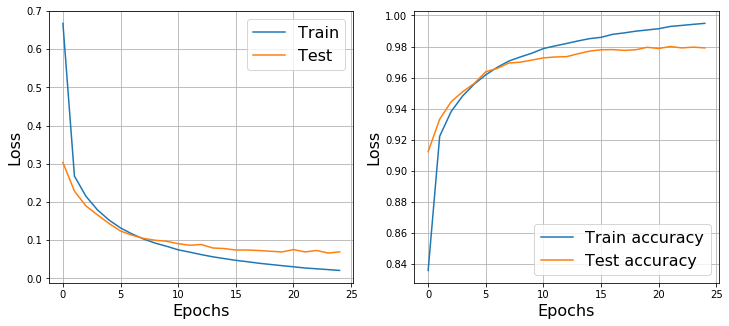

In [154]:
arch0_nn = Arch0()
train(arch0_nn, 25, 1e-4)

1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 

In [155]:
class Arch1(nn.Module):
    def __init__(self):
        super(Arch1, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 200), nn.ReLU(), nn.Dropout(),
                                           nn.Linear(200, 200), nn.ReLU(), nn.Dropout(),
                                           nn.Linear(200, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 24... (Train/Test) NLL: 0.107/0.131	Accuracy: 0.968/0.963


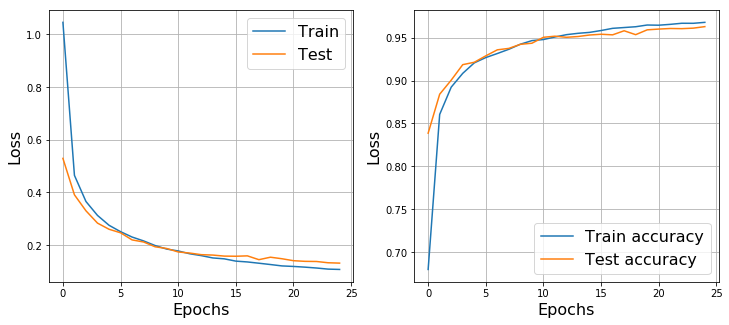

In [156]:
arch1_nn = Arch1()
train(arch1_nn, 25, 1e-4)

2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев


In [157]:
class Arch2(nn.Module):
    def __init__(self):
        super(Arch2, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 200), nn.ReLU(), 
                                           DropConnect(200, 200, p=0.5), nn.ReLU(),
                                           DropConnect(200, 10, p=0.5), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 24... (Train/Test) NLL: 1.754/1.743	Accuracy: 0.544/0.565


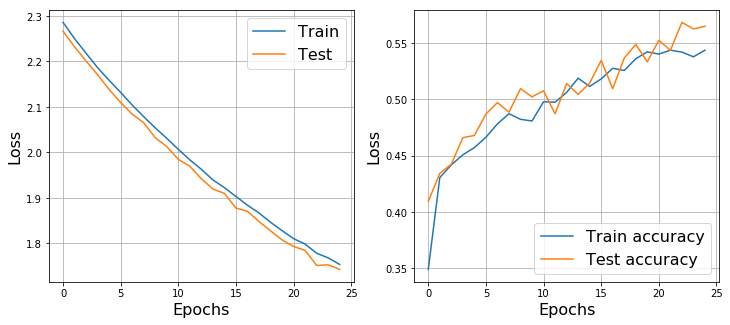

In [158]:
arch2_nn = Arch2()
train(arch2_nn, 25, 1e-4)

<i> 2.3 Сделайте выводы по третьей части </i>

Сеть с DropConnect показала себя хуже всего. Сеть с Dropout показала себя хуже, чем сеть без него, но заметно, что с Dropout склонность к переобучению меньше, хоть и сходимость дольше.

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [170]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self):
        super(LayerNormalization, self).__init__()
    def forward(self, x):
        output = (x - x.mean(-1, keepdim=True)) / x.std(-1, keepdim=True)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [173]:
class Arch3(nn.Module):
    def __init__(self):
        super(Arch3, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 200), nn.BatchNorm1d(200), nn.ReLU(),
                                           nn.Linear(200, 200), nn.BatchNorm1d(200), nn.ReLU(),
                                           nn.Linear(200, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 24... (Train/Test) NLL: 0.003/0.076	Accuracy: 1.000/0.981


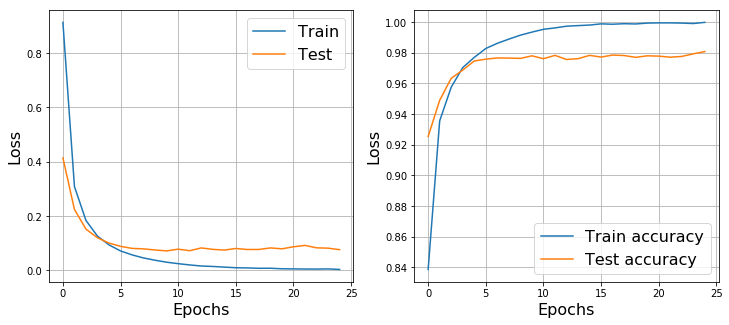

In [174]:
arch3_nn = Arch3()
train(arch3_nn, 25, 1e-4)

In [171]:
class Arch4(nn.Module):
    def __init__(self):
        super(Arch4, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 200), LayerNormalization(), nn.ReLU(),
                                           nn.Linear(200, 200), LayerNormalization(), nn.ReLU(),
                                           nn.Linear(200, 10), nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 24... (Train/Test) NLL: 0.002/0.090	Accuracy: 1.000/0.976


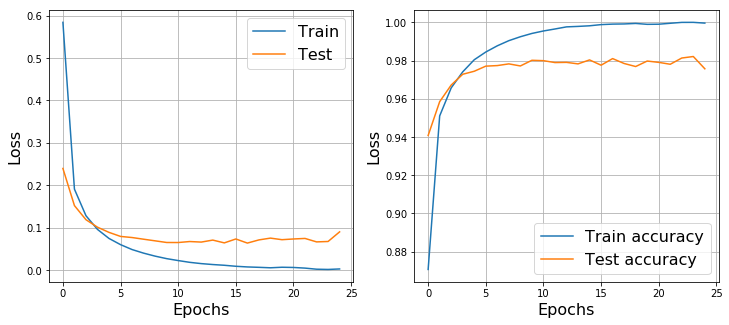

In [172]:
arch4_nn = Arch4()
train(arch4_nn, 25, 1e-4)

<i> 3.3 Сделайте выводы по третьей части </i>

Графики практически не отличаются, у батч-нормализации чуть лучше. С нормализацией результаты на тесте оказались наилучшими, если сравнивать с сетью без нормализаций и dropout, и сетью без нормализаций и без dropout.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: